In [1]:


import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
stocks = pd.read_csv('TCS.csv')


In [11]:
stocks.tail()

,Unnamed: 0,Date,Low,High,Close,Open
1255,4,2013-11-07,34.120,36.80,35.31,36.80
1256,3,2013-11-06,35.610,36.49,35.90,35.61
1257,2,2013-11-05,34.821,35.50,35.35,35.11
1258,1,2013-11-04,34.690,36.80,35.35,36.80
1259,0,2013-11-01,32.100,37.00,36.20,35.00


c:\users\rohan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='density')` instead of `Series.plot('density',)`.
  """


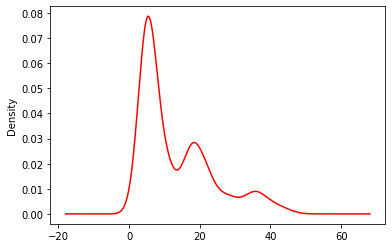

In [66]:
data_to_use = stocks['Close'].values

# stocks from 1 nov 2013 to 1 nov 2018 

stocks['Close'].plot('density',color='Red')


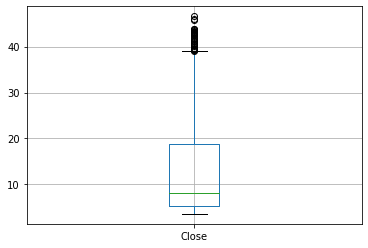

In [67]:
data_to_use

stocks.boxplot(column='Close')

# 

Total number of days in the dataset: 1260


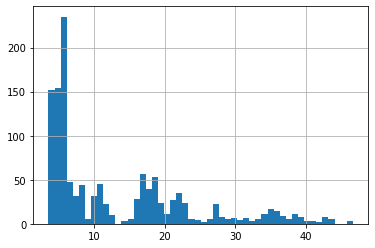

In [68]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))
# 1260 days 

# visualize data 
stocks['Close'].hist(bins=50)


In [9]:
scaler = StandardScaler()
# creates an array of arrays [ [1] , [2] ,..]
# and 
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))
print(scaled_dataset[3])


[-0.3423581]


In [1]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TCS stocks from August 2014 to August 2018')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()


NameError: name 'plt' is not defined

In [13]:
# data window for 
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

X, y = window_data(scaled_dataset, 7)

In [20]:
# X has 0 - 6 stock elem upper bound non inclusive
X[3]

array([[-0.3423581 ],
       [-0.35400194],
       [-0.34332842],
       [-0.35400194],
       [-0.29287179],
       [-0.31712978],
       [-0.32198138]])

In [21]:
# the last element is stored in y 
y[3]

array([-0.27346539])

In [24]:
# Have taken 7 percent of dataet (1172  days) as testing rest is training  ( ~81 days) 
# taken by approximation 
X_train  = np.array(X[:1172])
y_train = np.array(y[:1172])

X_test = np.array(X[1172:])
y_test = np.array(y[1172:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))


X_train size: (1172, 7, 1)
y_train size: (1172, 1)
X_test size: (81, 7, 1)
y_test size: (81, 1)


In [26]:
epochs = 200  #the whle dataset will pass through the model (RNN )200 times 
batch_size = 7 # difficult to fit the whole model at once hence we divide it into batches of 7 


# initialize an LSTM cell 
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8): # 0.8 dropout for preventing overfitting 
    
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size) 
    # Basic  creates a LSTM layer and instantiates variables for all gates.
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate) 
        #Operator adding dropout to inputs and outputs of the given cell. 

     # stacking multiple RNN cells 
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers)
     # initializer of statw of all RNN cells
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state



def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :] #start, stop, step 
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias') # set bias shifting the acticvation fucntion as desired 
    
    output = tf.matmul(x, weights) + bias # output is  ( x * weight) +bias  # main function of LSTM 
    return output




def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    # we are using adam optimizer 
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer



class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=7): # learning rate is kept low due to the graph of stock being sensitive  and not a standard curve . 
      # placeholders are non trainable vectors ( eg i/p o/p not bias wt's )
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')
         
         # initialize the cells 
        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)
        
         # logits are probablity outputs 
        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)
        
        # calculate loss and opt at each epoch using curr output logits 
        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)


# reset the network 
tf.reset_default_graph()
model = StockPredictionRNN()
#attach model variable to the RNN/LSTM 


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("strided_slice:0", shape=(7, 512), dtype=float32)
Instructions for updating:


Training 


In [27]:
session =  tf.Session()


session.run(tf.global_variables_initializer())

for i in range(epochs): 
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size] # give data batch wise to the model 
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.011550737544894218
Epoch 30/200  Current loss: 0.0025001929607242346
Epoch 60/200  Current loss: 0.002245329087600112
Epoch 90/200  Current loss: 0.0020508889574557543
Epoch 120/200  Current loss: 0.0021185646764934063
Epoch 150/200  Current loss: 0.00192491733469069
Epoch 180/200  Current loss: 0.0018824499566107988


In [37]:
sup =[]  # training data for later graph plot 
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

tests = []
i = 0

# fill tests[] with preducted data 
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)


tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

test_results = []
for i in range(1250):
    if i >= 1173:
        test_results.append(tests_new[i-1173])
    else:
        test_results.append(None)


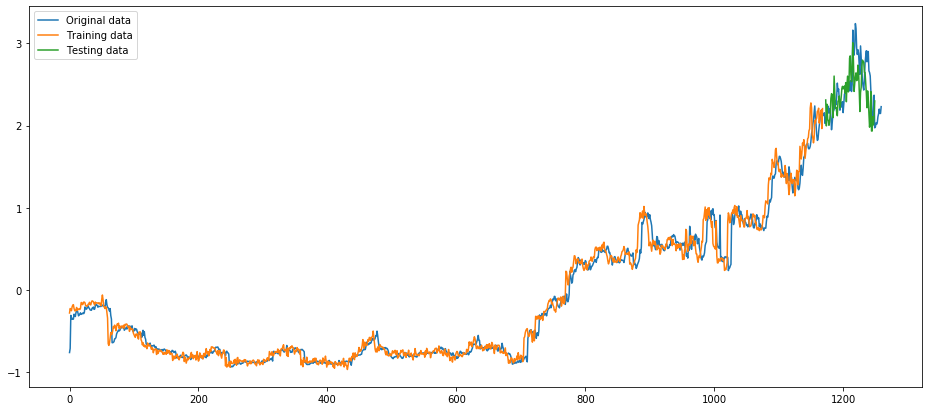

In [69]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_dataset, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()